# ML4CV Assignement 
0001138663 
Alberto Genovese 
alberto.genovese5@studio.unibo.it

## This notebook summarize all the work made for the assignement of the exam ML4CV.


The focus of the notebook is to test and compare three methods for anomaly detection in semantic segmentation. These three methods are: "Open World Semantic Segmentation Including Class Similarity" [(https://arxiv.org/abs/2403.07532)], "Standardized Max Logits: A Simple yet Effective Approach for Identifying Unexpected Road Obstacles in Urban Scene Segmentation" [(https://arxiv.org/abs/2107.11264)] and "Deep Metric Learning for Open World Semantic Segmentation" [(https://arxiv.org/abs/2108.04562)]

The first method utilizes a custom architecture with one encoder and two different decoders, one for semantic segmentation and the other for anomaly detection, with custom loss functions for both.

The second method is model agnostic; it focuses on using the logits produced by the model to find anomalies.

The third method uses a classical DeepLabV3+ architecture but with a custom losses that focus on learning a precise structure of the features in order to calculate the anomaly map

## Before starting with the 3 methods there is a preliminary part where every utlity is initialized

### Download of the weights and the source file needed for the notebook

In [1]:
#Download of the weights for resnet34
!gdown https://drive.google.com/drive/folders/11UBNiSbg1dvmvUCTnScMf0bb1P5QHnrl?usp=sharing --folder

#Download of the network structure
"""
code for the neural network model taken from https://github.com/PRBonn/ContMAV/tree/master/src/models
"""
!gdown https://drive.google.com/drive/folders/16UjFV-zWcWO2mJPSbTBR4K0talyauq1d?usp=sharing --folder

#Download the various model 
!gdown https://drive.google.com/file/d/1JjzTNzLbhqnWsASxSG3_kqpV_VjFWOPJ/view?usp=sharing --fuzzy

Retrieving folder contents
Processing file 1MnUQsiB_33qmSl9J4MKwM93KU15J_xoR r34_NBt1D.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1MnUQsiB_33qmSl9J4MKwM93KU15J_xoR
To: /kaggle/working/pretrained_weight/r34_NBt1D.pth
100%|██████████████████████████████████████| 61.3M/61.3M [00:00<00:00, 62.1MB/s]
Download completed
Retrieving folder contents
Processing file 1z1wGQQEtJJWTlaxNjPetS0TH4m73TWE9 build_model.py
Processing file 1BO2xUrZM6p9smLaxc8CiZO13Cbkz0XFA context_modules.py
Processing file 1zJEHbspXwy4gjPsrpH6581dRdQKwLnKB model_one_modality.py
Processing file 1WoIuvTK3qeIW_yBqC7oZc8hvNUCPnyIG model_utils.py
Processing file 1bOK4momkV_32rqZnal3rbIQtcIYM93MD model.py
Processing file 1DHx1bHqIFqCN6rTt31849voMjCsIxlUA resnet.py
Processing file 1vKB2ZaCCnCXzvtWTapmn4j7G-JmQZ4Od rgb_depth_fusion.py
Retrieving folder contents completed
Building directory structure
Building dire

In [2]:
!mkdir -p Weights
!unzip ML4CV.zip -d Weights
!rm -r ML4CV.zip 

Archive:  ML4CV.zip
   creating: Weights/ML4CV/
   creating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross1_feat0.9mean_lr0.0001/
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross1_feat0.9mean_lr0.0001/DualDecoder_best_50.pth  
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross1_feat0.9mean_lr0.0001/DualDecoder_best.pth  
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross1_feat0.9mean_lr0.0001/DualDecoder_val_loss.npy  
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross1_feat0.9mean_lr0.0001/DualDecoder_train_loss.npy  
   creating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross0.9_feat0.1mean_lr0.0001/
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross0.9_feat0.1mean_lr0.0001/DualDecoder_best_50.pth  
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_thre1_t0.1_cross0.9_feat0.1mean_lr0.0001/DualDecoder_best.pth  
  inflating: Weights/ML4CV/50_epoch_obje0.5_contr0.5_t

## Installing the dependeciens

In [3]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=b83b5d75e827faf80eded38901f51137e341b43863d00f0e6ac419b481575e3d
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=29c6026389c8d2af0fe8c79ade1bf4764a4f5cdd2b630b1fe296a9cd4806fe39
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [4]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## Imports

In [5]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from typing import Optional, Callable, Union, Tuple, Dict, List
from enum import IntEnum
from torch import Tensor
from torchvision import transforms
from torchvision.transforms import v2
from models.build_model import build_model
import re
import json
from pathlib import Path
from IPython.display import display
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm
from PIL import Image
import random
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from fvcore.nn import FlopCountAnalysis, parameter_count
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import kornia.morphology as morphology
import kornia.filters as filters
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Utility function
These functions are mainly used to organize the various model weights by taking their path and putting them in a dictionary.

In [6]:
def get_model_by_key(all_models_dict, model_key):
    if model_key in all_models_dict:
        return {model_key: all_models_dict[model_key]}
    else:
        print(f"Attenzione: la chiave '{model_key}' non è stata trovata nel dizionario.")
        return {}


def create_column(nome_file):
    parti = nome_file.split('_')
    dati_analizzati = {}

    if len(parti) > 1 and parti[1] == 'epoch':
        try:
            dati_analizzati['epoch'] = int(parti[0])
            parti = parti[2:]
        except ValueError:
            pass 


    for parte in parti:
        corrispondenza = re.match(r"([a-zA-Z]+)(.*)", parte)
        if corrispondenza:
            chiave = corrispondenza.group(1)
            valore_str = corrispondenza.group(2)

            if not valore_str:
                continue
            try:
                if '.' in valore_str:
                    dati_analizzati[chiave] = float(valore_str)
                else:
                    dati_analizzati[chiave] = int(valore_str)
            except ValueError:
                mixed_match = re.match(r"([0-9\.]+)([a-zA-Z]+)", valore_str)
                if mixed_match:
                    numeric_part_str = mixed_match.group(1)
                    text_part_str = mixed_match.group(2)
    
                    try:
                        if '.' in numeric_part_str:
                            dati_analizzati[chiave] = float(numeric_part_str)
                        else:
                            dati_analizzati[chiave] = int(numeric_part_str)
                            
                        dati_analizzati[f"{chiave}_suffix"] = text_part_str
                    except ValueError:

                        dati_analizzati[chiave] = valore_str
                else:

                    dati_analizzati[chiave] = valore_str
        else:
            print(f"Attenzione: la parte '{parte}' non ha potuto essere analizzata.")

    return dati_analizzati



def organize_model_dictionaries(base_path):
    dual_decoder_models = {}
    segmentation_models = {}
    deepMetri_models = {}

    if not os.path.exists(base_path):
        print(f"Attenzione: il percorso specificato non esiste: {base_path}")
        return dual_decoder_models, segmentation_models

    for model_dir_name in os.listdir(base_path):
        model_path = os.path.join(base_path, model_dir_name)

        if os.path.isdir(model_path):
            model_data = {
                "weights_best": None,
                "weight_last": None,
                "train_losses": None,
                "val_losses": None
            }
            
            found_weights = []
            for filename in os.listdir(model_path):
                full_file_path = os.path.join(model_path, filename)
     
                if "train_loss" in filename.lower():
                    model_data["train_losses"] = full_file_path
                elif "val_loss" in filename.lower():
                    model_data["val_losses"] = full_file_path
                elif filename.endswith(('.pt', '.pth', '.h5', '.weights')):
                    found_weights.append(full_file_path)

            other_weights = []
            for weight_path in found_weights:
                if "best" in os.path.basename(weight_path).lower():
                    model_data["weights_best"] = weight_path
                else:
                    other_weights.append(weight_path)

            if other_weights:
                model_data["weight_last"] = other_weights[0]

            if model_dir_name == "50_epoch_CrossEntropy_segmentationStandard_lr0.0001":
                segmentation_models[model_dir_name] = model_data
            elif "DMLLoss" in model_dir_name:
                deepMetri_models[model_dir_name] = model_data
            else:
                dual_decoder_models[model_dir_name] = model_data

    return dual_decoder_models, segmentation_models, deepMetri_models

In [7]:
Dual_decoder_models, segmentation_models,deepMetric_models = organize_model_dictionaries("/kaggle/working/Weights/ML4CV")

## General variables

In [8]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
DATA_DIR = "./data"
known_classes = 13

#path to streethazards dataset
train_odgt_file = f"{DATA_DIR}/streethazards_train/train.odgt"
val_odgt_file = f"{DATA_DIR}/streethazards_train/validation.odgt"
test_odgt_file = f"{DATA_DIR}/streethazards_test/test.odgt"

height = 512
width = 896


"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
[  0,   0,   0], # // unlabeled     =   0, black
[ 70,  70,  70], # // building      =   1, gray
[190, 153, 153], # // fence         =   2, pinkish
[250, 170, 160], # // other         =   3, pink
[220,  20,  60], # // pedestrian    =   4, 
[153, 153, 153], # // pole          =   5,
[157, 234,  50], # // road line     =   6, 
[128,  64, 128], # // road          =   7,
[244,  35, 232], # // sidewalk      =   8,
[107, 142,  35], # // vegetation    =   9, 
[  0,   0, 142], # // car           =  10,
[102, 102, 156], # // wall          =  11, 
[220, 220,   0], # // traffic sign  =  12,
[ 60, 250, 240], # // anomaly       =  13,
]) 

class StreetHazardsClasses(IntEnum):
    UNLABELED       = 0
    BUILDING            = 1
    FENCE           = 2
    OTHER           = 3
    PEDESTRIAN      = 4
    POLE            = 5
    ROAD_LINE       = 6
    ROAD            = 7
    SIDEWALK        = 8
    VEGETATION      = 9
    CAR             = 10
    WALL            = 11
    TRAFFIC_SIGN    = 12
    ANOMALY         = 13

## Downloading the streethazards dataset

In [9]:
!mkdir -p $DATA_DIR
!test ! -d $DATA_DIR/train \
    && wget -O $DATA_DIR/train.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar \
    && tar -xf $DATA_DIR/train.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/train.tar \
    && mv $DATA_DIR/train $DATA_DIR/streethazards_train
!test ! -d $DATA_DIR/test \
    && wget -O $DATA_DIR/test.tar https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar \
    && tar -xf $DATA_DIR/test.tar -C $DATA_DIR \
    && rm -r $DATA_DIR/test.tar\
    && mv $DATA_DIR/test $DATA_DIR/streethazards_test

--2025-11-28 16:09:03--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9386226176 (8.7G) [application/x-tar]
Saving to: ‘./data/train.tar’

./data/train.tar    100%[===================>]   8.74G  40.5MB/s    in 2m 13s  

2025-11-28 16:11:16 (67.2 MB/s) - ‘./data/train.tar’ saved [9386226176/9386226176]

--2025-11-28 16:11:36--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘./data/test.tar’

./data/test.tar     100%[==================

# Metrics


## AUPR 
The main metric for anomaly detection is the AUPR, which is the area under the precision recall curve. In simple terms, AUPR is a metric that measures the performance of a classification model by summarizing its Precision Recall curve into a single number, ranging from 0 to 1.

In [10]:
class AUPR:
    """
    Compute the mean Average Precision (AUPR) for binary anomaly detection tasks.

    Attributes:
        anomaly_idx (int): The class index considered as anomaly.
        mean_aupr (List[float]): Stores AUPR values per sample for averaging.
    """
    
    def __init__(self, anomaly_idx: int = 13):
        
        self.mean_aupr = []
        self.anomaly_idx = anomaly_idx

    def update(self, anomaly_score: torch.Tensor, labels: torch.Tensor) -> None:
        """
        Update the internal AUPR list with new batch of predictions and labels.
        """
    
        for i in range(anomaly_score.shape[0]):
            
            preds, lbl = anomaly_score[i], (labels[i] == self.anomaly_idx)
            
            if preds.dim() == 2: preds = preds.unsqueeze(0)
            if lbl.dim() == 2: lbl = lbl.unsqueeze(0)
            preds, lbl = preds.cpu(), lbl.cpu()
            self.mean_aupr.append(average_precision_score(lbl.type(torch.int32).flatten().numpy(),preds.type(torch.float32).flatten().numpy()))
            
    def get_results(self) -> float:
        """
        Get the mean AUPR score across all processed batches.

        Returns:
            float: Mean AUPR value.
        """
        
        return sum(self.mean_aupr)/len(self.mean_aupr)
    def reset(self) :
        self.mean_aupr = []

## Mean IoU
IoU, which stands for Intersection over Union, is a metric used to measure the accuracy of a segmentation prediction. In simple terms, it calculates how much a model's predicted segmentation for an object (or a class) overlaps with the actual ground truth segmentation. In our case, we use the mean IoU because we have multiple classes, each with its own IoU.

In [11]:
class MeanIoU:
    """
    Computes the mean Intersection over Union for multi-class semantic segmentation.

    Based on implementation from:
    https://github.com/Jun-CEN/Open-World-Semantic-Segmentation

    Attributes:
        n_classes (int): Number of classes in the segmentation task.
        confusion_matrix (np.ndarray): Running total confusion matrix.
    """
    
    def __init__(self, n_classes: int = len(COLORS)-1):
        """
        Initialize the MeanIoU evaluator.

        Args:
            n_classes (int): Number of segmentation classes. Defaults to `StreetHazardsClasses.ANOMALY`.
        """
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
    
    def reset(self) :
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))       
        
    def update(self, label_trues: torch.Tensor, logits: torch.Tensor, segmentated = False, prediction_on_cpu = False) -> None:
        """
        Update the internal confusion matrix using predicted and ground truth labels.

        Args:
            label_trues (torch.Tensor): Ground truth labels of shape (B, H, W).
            logits (torch.Tensor): Model output logits of shape (B, C, H, W).
        """
        
        if not segmentated:
            label_preds = torch.argmax(logits, dim=1)
        else :
            label_preds = logits
        if not prediction_on_cpu:
            label_preds, label_trues = label_preds.cpu().numpy(), label_trues.cpu().numpy()
        else :
            label_trues = label_trues.cpu().numpy()
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten())

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self) -> Dict:
        """
        Compute evaluation metrics from the accumulated confusion matrix.

        Returns:
            Dict[str, Any]: A dictionary containing:
                - "Mean IoU" (float): Mean intersection over union across all classes.
                - "Class IoU" (dict): Per-class IoU scores.
        """
        hist = self.confusion_matrix

        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu, axis= 0)
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
            }

## Visualization function
These functions are used to visualize both RGB images and segmentation maps.

In [12]:
def visualize_annotation(annotation_img: np.ndarray | torch.Tensor, ax=None, title= None) -> None:
    """
    Visualize a segmentation annotation using a predefined color palette.

    Args:
        annotation_img (np.ndarray | torch.Tensor): 2D array with class indices.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    if title:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_scene(image: np.ndarray | torch.Tensor, ax=None, title= None,sub_title= None) -> None:
    """
    Visualize a raw RGB scene image.

    Args:
        image (np.ndarray | torch.Tensor): Image tensor or array in [C, H, W] or [H, W, C] format.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, uses current axis.
    """
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    if len(image.shape) == 2:
        ax.imshow(image)
    else:
        ax.imshow(np.moveaxis(image, 0, -1))
    if title:
        ax.set_title(title)
    if sub_title:
        ax.figtext(0.5, 0.01, sub_title, wrap=True, horizontalalignment='center', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

## Statistics computation function
These functions are used to calculate useful statistics throughout the notebook.

In [13]:
def compute_mean_std_channels(dataset: torch.utils.data.Dataset) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the per-channel mean and standard deviation across all images in a dataset.

    This function is used when you want to normalize your dataset with statistics computed from your own data rather than relying on precomputed values like ImageNet mean/std.

    Args:
        dataset (torch.utils.data.Dataset): A dataset from which compute the mean and standard deviation.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: 
            - mean: A tensor of shape (C,) containing the average value for each channel.
            - std: A tensor of shape (C,) containing the standard deviation for each channel.
    """
    
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    nb_samples = 0

    for batch in tqdm(data_loader):
        images = batch["image"]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1) 
    
        mean += images.mean(2).sum(0)  
        std += images.std(2).sum(0)
        nb_samples += batch_samples 
        del batch

    mean /= nb_samples
    std /= nb_samples
    return mean, std

def compute_class_frequency(
    dataset: None,
    num_classes: int,
    normalize: bool = False,
    ax = None,
    caption: str = '',
) -> torch.Tensor:
    
    """
    Compute the frequency of pixels per class, given a dataset

    Args:
        dataset (Dataset): A PyTorch dataset object that yields samples with a 'labels' key.
        num_classes (int): The number of unique classes in the dataset.
        normalize (bool, optional): Whether to normalize the computed weights to sum to the number of classes.
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes object to draw the frequency plot on (required if plot_frequencies is True).
        caption (str): title to use for the plot

    Returns:
        torch.Tensor: A tensor of shape (num_classes,) containing the inverse frequency weights for each class.
    """
    
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    pixels_per_class = torch.zeros(num_classes, dtype=torch.float32)

    for batch in tqdm(data_loader):
        labels = batch['labels'] 
        labels = labels.view(-1) 
        counts = torch.bincount(labels, minlength=num_classes)
        pixels_per_class += counts

    total_pixels = pixels_per_class.sum()

    return pixels_per_class


def plot_class_frequency(
    pixels_per_class: List[int],
    total_pixels: int,
    ax, 
    caption: str = ''
) -> None:
    
    """
    Plot the percentage of pixels per class in a horizontal bar chart. Used in combination with compute_class_frequency

    Parameters:
        pixels_per_class (Sequence[int]): A sequence containing the pixel count for each class.
        total_pixels (int): The total number of pixels across all classes.
        ax (matplotlib.axes.Axes): A matplotlib Axes object where the chart will be drawn.
        caption (str): title to use for the plot
    """
    
    class_names = [cls.name.title().replace("_", " ") for cls in StreetHazardsClasses if cls.value < len(pixels_per_class)]
    percentages = (pixels_per_class / total_pixels) * 100
    #class_names = list(range(len(pixels_per_class)))
    indices = list(range(len(pixels_per_class)))
    
    bars = ax.barh(indices, percentages, color='skyblue')

    ax.set_ylabel('Class Name', fontsize=12)
    ax.set_xlabel('Total Pixel Count', fontsize=12)
    ax.set_title(f'{caption} Pixel Frequencies Per Class', fontsize=14)
    ax.set_yticks(indices)
    ax.set_yticklabels(class_names, rotation=0, fontsize=10)
    ax.tick_params(axis='x', labelsize=10)

    for bar in bars:
        xval = bar.get_width()
        ax.text(xval + (max(percentages) * 0.01), 
                 bar.get_y() + bar.get_height() / 2,
                 f'{xval:.3f}%', ha='left', va='center', fontsize=9)

def calculate_statistics(model, data_loader, num_classes, device):
    model.eval()

    counts = np.zeros(num_classes, dtype=np.int64)
    means = np.zeros(num_classes, dtype=np.float64)
    M2s = np.zeros(num_classes, dtype=np.float64)

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="computing the statistics")
        for batch in progress_bar:
            images = batch["image"].to(device)
            
            logits = model(images)
            if isinstance(logits, dict):
                logits = logits['out']
            if isinstance(logits,tuple):
                logits, _ = logits

            logits_np = logits.detach().cpu().numpy()

            for i in range(logits_np.shape[0]): 
                logit_map = logits_np[i]
                max_logits = np.max(logit_map, axis=0)
                predictions = np.argmax(logit_map, axis=0)

                for c in range(num_classes):
                    mask = (predictions == c)
                    values_for_class_c = max_logits[mask]

                    if values_for_class_c.size == 0:
                        continue

                    n_B = values_for_class_c.size
                    mean_B = np.mean(values_for_class_c)
                    var_B = np.var(values_for_class_c)
                    M2_B = var_B * n_B
                    
                    n_A = counts[c]
                    mean_A = means[c]
                    M2_A = M2s[c]


                    n_new = n_A + n_B
                    delta = mean_B - mean_A
                    
                    mean_new = mean_A + delta * n_B / n_new
                    M2_new = M2_A + M2_B + (delta**2) * n_A * n_B / n_new
                    
                    counts[c] = n_new
                    means[c] = mean_new
                    M2s[c] = M2_new
    
    epsilon = 1e-8
    variances = M2s / (counts + epsilon)
    stds = np.sqrt(variances)
    
    for c in range(num_classes):
        if counts[c] == 0:
            print(f"Attenzione: Nessun pixel è stato predetto per la classe {c}. Vengono usati valori di default.")
            means[c] = 0.0
            stds[c] = 1.0

    return means.astype(np.float32), stds.astype(np.float32)


## Dataset functions
These functions create the 2 datasets used in the notebook.
    1 - The first one is to load the base StreetHazards dataset, in which only the test set has anomalies.
    2 - The second one is to load the anomaly injected version of the StreetHazards dataset. This was done because the "Open World Semantic Segmentation Including Class Similarity" method required anomalies at test time for the contrastive decoder. The anomalies have been injected from the SBDataset [(https://docs.pytorch.org/vision/main/generated/torchvision.datasets.SBDataset.html)] downloaded from torchvision.

In [14]:
class StreetHazardsDataset(Dataset):
    """
    A custom PyTorch Dataset for the StreetHazards inliner dataset.

    This dataset reads image and segmentation label paths from a `.odgt` file,
    applies optional resizing and spatial transformations, and returns
    dictionary-style samples with normalized image tensors and label tensors.

    Args:
        odgt_file (str): Path to the `.odgt` file containing image and label metadata.
        image_resize (Tuple[int, int], optional): Target size to resize images and labels. 
        spatial_transforms (Callable, optional): Optional transformation function applied to both images and labels.
        mean_std (Tuple[List[float], List[float]], optional): Mean and standard deviation for image normalization.
        
    """
    def __init__(
        self,
        odgt_file: str,
        image_resize: Tuple[int, int] = (512, 896),
        spatial_transforms: Optional[Callable] = None,
        mean_std: Tuple[List[float], List[float]] = None,
        image_only_transforms: Optional[Callable] = None,
    ):

        self.spatial_transforms = spatial_transforms
        self.mean_std = mean_std
        self.image_resize = image_resize
        self.image_only_transforms = image_only_transforms

        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)
        

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
            }
            for data in odgt_data 
        ]
    
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:

        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])

        if self.image_resize:
            image = transforms.Resize(self.image_resize, transforms.InterpolationMode.BILINEAR)(image)
            labels = transforms.Resize(self.image_resize, transforms.InterpolationMode.NEAREST)(labels)
            
        if self.spatial_transforms:
            image, labels  = self.spatial_transforms(image, labels)         

        if self.image_only_transforms:
            image = self.image_only_transforms(image)

        labels_tensor_raw = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64)

        image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
        
        labels = labels.squeeze(0)
        
        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)
        

        return {'image' : image, 'labels' : labels}

class MixDataset(Dataset):
    """
    A custom PyTorch Dataset that combines an inlier (without anomalies) dataset with an outlier dataset 
    to synthetically generate training samples for anomaly detection tasks.
    Args:
        inlier_dataset (Dataset): Dataset containing normal images and segmentation labels.
        outlier_dataset (Dataset): Dataset containing anomalous images and segmentation labels.
        mean_std (Tuple, optional): Mean and std to apply to the image.
        anomaly_probability (float): Probability [0, 1] of injecting an anomaly into a given sample.
        max_anomalies (int): Maximum number of anomalies to inject per image.
        anomaly_idx (int): The label index used to represent injected anomalies in the segmentation map.
    """
    
    def __init__(
        self,
        inlier_dataset: Dataset,
        outlier_dataset: Dataset,
        mean_std: Tuple[List, List] = None,
        anomaly_probability: float = 1.0,
        max_anomalies: int = 4,
        anomaly_idx: int = 13):
        
        self.inlier_dataset = inlier_dataset
        self.outlier_dataset = outlier_dataset
        self.anomaly_idx = anomaly_idx
        self.anomaly_probability = anomaly_probability
        self.max_anomalies = max_anomalies
        self.mean_std = mean_std
    
    def __len__(self) -> int:
        return len(self.inlier_dataset)
        
    def inject_anomalies(self, image: Tensor, label: Tensor) -> tuple[Tensor, Tensor]:
        """
        Injects up to max_anomalies random anomalous patches into the image and label.

        Returns:
            image (Tensor): Modified image with anomalies.
            label (Tensor): Corresponding label with injected anomaly class index.
        """

        n_anomalies = random.randint(1, self.max_anomalies)
        for i in range(n_anomalies):

            rand_idx = random.randint(0, len(self.outlier_dataset)-1)

            anomaly_size = (np.random.randint(image.shape[1]*0.1, image.shape[1]*0.3), np.random.randint(image.shape[2]*0.1, image.shape[2]*0.3))
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=anomaly_size)
            possible_classes = []
            while len(possible_classes) == 0: # In some cases there are no classes available
                anomaly_idx = np.random.randint(0, len(self.outlier_dataset))
                anomaly_image = transforms.ToTensor()(self.outlier_dataset[anomaly_idx][0])
                anomaly_annot = torch.from_numpy(np.array(self.outlier_dataset[anomaly_idx][1])).unsqueeze(0)
                possible_classes = np.unique(anomaly_annot)[1:-1]

            anomaly_class = np.random.choice(possible_classes)
            anomaly_image = F.interpolate(anomaly_image.unsqueeze(0), size=(h, w), mode="bilinear").squeeze(0)
            anomaly_annot = F.interpolate(anomaly_annot.unsqueeze(0), size=(h, w), mode="nearest").squeeze((0, 1))

            # Insert anomaly
            image[:, i:i+h, j:j+w][:, anomaly_annot == anomaly_class] = anomaly_image[:, anomaly_annot == anomaly_class]
            label[i:i+h, j:j+w][anomaly_annot == anomaly_class] = self.anomaly_idx

        return image, label

    def __getitem__(self, idx: int) -> dict:

        image, label = self.inlier_dataset[idx].values()
        label_original = torch.clone(label)
        p = random.random()
        if p < self.anomaly_probability:
            image, label = self.inject_anomalies(image, label)
            w, h = label.shape[0], label.shape[1]

        if self.mean_std:
            image = transforms.Normalize(mean = self.mean_std[0], std = self.mean_std[1])(image)
            
        return {"image" : image,"labels_anomaly": label,"labels_original": label_original}

## Load Dataset
This function creates all the necessary dataloaders for the notebook.

The size of the images was reduced to 512 x 896 to decrease computational cost, which is around 1/4 of the original dimension, and to preserve the same aspect ratio of the original images.

In the standard configuration the mean and the std used for the datasets are the precalculated one, if you wish to recalculate them you can pass to the function 'LoadDataset()' the parameter 'COMPUTE_MEAN_STD=True'

In [15]:
def robust_sbd_download(root_dir, image_set):
    try:
        dataset = torchvision.datasets.SBDataset(root_dir, image_set=image_set, mode='segmentation', download=True)
    except Exception as e:
        dataset = torchvision.datasets.SBDataset(root_dir, image_set=image_set, mode='segmentation', download=False)
    return dataset

In [ ]:
def LoadDataset(COMPUTE_MEAN_STD=False,batch=8):
        shape_resize = (512, 896)


        if COMPUTE_MEAN_STD:
            mean_std = compute_mean_std_channels(StreetHazardsDataset(odgt_file= train_odgt_file,
                                                                                                   image_resize = shape_resize,
                                                                                                   spatial_transforms=None,
                                                                                                   mean_std=None))
        else:
            mean_std = [0.3302, 0.3459, 0.373], [0.1595, 0.1577, 0.1712]



        image_augmentations = transforms.Compose([
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
        ])
        
        
        
        spatial_transforms = transforms.v2.Compose([
            transforms.v2.RandomHorizontalFlip(),
        ])
        
        train_dataset = StreetHazardsDataset(
            odgt_file= train_odgt_file,
            image_resize = shape_resize,
            spatial_transforms=spatial_transforms,
            image_only_transforms=image_augmentations,
            mean_std=mean_std
        )
        
        val_dataset = StreetHazardsDataset(
            odgt_file= val_odgt_file,
            image_resize = shape_resize,
            spatial_transforms=None,
            mean_std=mean_std
        )
        
        test_dataset = StreetHazardsDataset(
            odgt_file= test_odgt_file,
            image_resize = shape_resize,
            spatial_transforms=None,
            mean_std=mean_std
        )
        
        train_dl = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=4,drop_last= True,pin_memory=True)
        val_dl = DataLoader(val_dataset, batch_size=batch, shuffle=True, num_workers=4,drop_last= True,pin_memory=True)
        test_dl = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=4,drop_last= True,pin_memory=True)

        dataset_train  = robust_sbd_download(DATA_DIR, image_set='train')
        dataset_val = robust_sbd_download(DATA_DIR, image_set='val')

        mix_train = MixDataset(inlier_dataset = train_dataset , 
                                              outlier_dataset = dataset_train, 
                                              mean_std = mean_std)

        mix_val = MixDataset(inlier_dataset = val_dataset, 
                                            outlier_dataset = dataset_val, 
                                            mean_std = mean_std)

        mix_train_dl = DataLoader(mix_train, batch_size=batch, shuffle=True, num_workers=2)
        mix_val_dl = DataLoader(mix_val, batch_size=batch, shuffle=True, num_workers=2)

        return train_dl, val_dl, test_dl, mix_train_dl, mix_val_dl

train_dl, val_dl, test_dl, mix_train_dl, mix_val_dl  = LoadDataset()

100%|██████████| 1.42G/1.42G [00:11<00:00, 122MB/s] 


## Anomaly detection with standardized max logit

This class is the one that performs anomaly detection with the max logit method from [(https://arxiv.org/abs/2107.11264)].

In [17]:
class AnomalyDetectorMaxLogit:

    def __init__(self, class_means, class_stds, device):
        self.device = torch.device(device)
        
        self.class_means = torch.tensor(class_means, dtype=torch.float32, device=self.device)
        self.class_stds = torch.tensor(class_stds, dtype=torch.float32, device=self.device)
        
        self.epsilon = 1e-8
        self.class_stds = torch.maximum(self.class_stds, torch.tensor(self.epsilon, device=self.device))

    def _standardize_max_logits(self, logits):


        max_logits, predictions = torch.max(logits, dim=1)
        

        means_at_pixels = self.class_means[predictions]
        stds_at_pixels = self.class_stds[predictions]
        
        sml_map = (max_logits - means_at_pixels) / stds_at_pixels
        return sml_map, predictions

    def _iterative_boundary_suppression(self, sml_map, predictions, num_iterations=4, initial_boundary_width=8, kernel_size=3):
        updated_sml = sml_map.clone()
        boundary_width_step = initial_boundary_width // num_iterations
        

        pool_kernel = torch.ones((1, 1, kernel_size, kernel_size), device=self.device) / (kernel_size**2)
        padding = (kernel_size - 1) // 2

        for i in range(num_iterations):
            boundary_width = initial_boundary_width - i * boundary_width_step
            if boundary_width <= 0: continue


            morph_kernel = torch.ones((boundary_width, boundary_width), device=self.device)
            

            preds_unsqueezed = predictions.unsqueeze(1).float()
            
      
            eroded_preds = morphology.erosion(preds_unsqueezed, morph_kernel)
            dilated_preds = morphology.dilation(preds_unsqueezed, morph_kernel)
            boundary_mask = (dilated_preds != eroded_preds).squeeze(1) # Rimuovi la dimensione dei canali
            non_boundary_mask = ~boundary_mask

            sml_unsqueezed = updated_sml.unsqueeze(1)
            sml_times_mask = sml_unsqueezed * non_boundary_mask.unsqueeze(1).float()
            
            sum_sml_neighbors = F.conv2d(sml_times_mask, pool_kernel, padding=padding)
            
            count_non_boundary_neighbors = F.conv2d(non_boundary_mask.unsqueeze(1).float(), pool_kernel, padding=padding) * (kernel_size**2)
            
            bap_values = sum_sml_neighbors / (count_non_boundary_neighbors + self.epsilon)
            
            updated_sml = torch.where(boundary_mask, bap_values.squeeze(1), updated_sml)

        return updated_sml

    def _dilated_smoothing(self, sml_map, kernel_size=7, sigma=1.0, dilation_rate=6):
        sml_unsqueezed = sml_map.unsqueeze(1)
        padding = (kernel_size - 1) // 2 * dilation_rate

        ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1., device=self.device)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
        kernel = kernel / torch.sum(kernel)
        kernel = kernel.view(1, 1, kernel_size, kernel_size)

        # 2. Applica la convoluzione con dilatazione
        smoothed_map = F.conv2d(sml_unsqueezed, kernel, padding=padding, dilation=dilation_rate)
        
        return smoothed_map.squeeze(1)

    def get_anomaly_map(self, logits):
        if not isinstance(logits, torch.Tensor):
            raise TypeError(f"Input must be a torch.Tensor, but got {type(logits)}")

        logits = logits.to(self.device)

        is_batch = logits.dim() == 4
        if not is_batch:
            logits = logits.unsqueeze(0) # Aggiungi la dimensione del batch

        sml_map, predictions = self._standardize_max_logits(logits)

        sml_suppressed = self._iterative_boundary_suppression(sml_map, predictions)

        sml_smoothed = self._dilated_smoothing(sml_suppressed)

        anomaly_map = -sml_smoothed

        if not is_batch:
            anomaly_map = anomaly_map.squeeze(0) # Rimuovi la dimensione del batch se non c'era

        return anomaly_map

## First method Losses "Open World Semantic Segmentation Including Class Similarity"

As previously stated, this method utilizes a custom network composed of an encoder and two decoders, so it uses two different loss functions, one for each decoder.

### SD_loss

This loss is used to train the semantic decoder; it aims to learn the semantic segmentation map for the closed world set. There are two main parts to the loss. The first is the classical segmentation part, for which the weighted Cross Entropy is used.

$$
\mathcal{L}_{sem} = - \frac{1}{|\Omega|} \sum_{p \in \Omega} w_k \mathbf{t}_p^T \log(\sigma(\mathbf{f}_p))
$$

The second part of the loss aims to build a class descriptor for each class by using the pre softmax features and the per-class means and variances.

This formula calculates the mean feature vector, or "prototype," for each class $k$. It's computed by averaging the feature vectors of all pixels that were correctly classified as class $k$ (True Positives).

$$
\boldsymbol{\mu}_k = \frac{1}{|\hat{\Omega}_k|} \sum_{p \in \hat{\Omega}_k} \mathbf{f}_p
$$

-   $\hat{\Omega}_k$: The set of true positive pixels for class $k$ (i.e., pixels where both ground truth and prediction are $k$).

This calculates the element wise variance of the feature vectors for all true positive pixels of class $k$, relative to their class prototype $\boldsymbol{\mu}_k$.

$$
\boldsymbol{\sigma}_k^2 = \frac{1}{|\hat{\Omega}_k|} \sum_{p \in \hat{\\Omega}_k} (\mathbf{f}_p - \boldsymbol{\mu}_k)^2
$$

This is an additional loss for the semantic decoder that pushes the feature vectors $\mathbf{f}_p$ of a class $k$ closer to the stable class prototype $\boldsymbol{\mu}_k^{e-1}$ calculated in the previous epoch. The difference is standardized by the variance.

$$
\mathcal{L}_{feat} = \frac{1}{|\Omega|} \sum_{k=1}^K \sum_{p \in \Omega_k} \left\| \frac{\mathbf{f}_p - \boldsymbol{\mu}_k^{e-1}}{\boldsymbol{\sigma}_k^{e-1}} \right\|_2^2
$$

-   $\Omega_k$: The set of pixels where the ground truth is $k$.
-   $\boldsymbol{\mu}_k^{e-1}$ and $\boldsymbol{\sigma}_k^{e-1}$: The mean and standard deviation from the previous epoch.

In [18]:
class SD_loss(nn.Module):
    def __init__(self, device: torch.device,inverse_class_weights,num_classes,cross_weight,feat_weight):
        super().__init__()
        self.device = device
        self.inverse_class_weights = inverse_class_weights
        self.num_classes = num_classes
        self.cross_weight = cross_weight
        self.feat_weight = feat_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=inverse_class_weights, ignore_index=-1)
    
    def forward(self,logits,targets,previous_means=None,previous_variances=None):

        C_loss = elf.cross_entropy_loss(logits, targets)

        if previous_means is None or previous_variances is None:
            return l_sem

        total_feat_loss = 0.0
        logits_permuted = logits.permute(0, 2, 3, 1)
        
        for c in range(self.num_classes):
            class_mask = (targets == c)
            if class_mask.sum() == 0:
                continue

            features = logits_permuted[class_mask]
            c_mean = previous_means[c]
            c_variance = previous_variances[c]
            c_std = torch.sqrt(c_variance) + 1e-6

            standardized_diff = (features - c_mean) / c_std
            total_feat_loss += torch.pow(standardized_diff, 2).sum()
        
        l_feat = total_feat_loss / (targets.numel()) # Normalizza per tutti i pixel

        return self.cross_weight * l_sem + self.feat_weight * l_feat

### CD_loss

This loss is used to train the contrastive decoder, which aims to learn the basis for the anomaly map. There are two main parts to the loss. The first is the contrastive loss, defined as follows:

$$
\mathcal{L}_{cont} = - \sum_{k=1}^K \log \left[ \frac{\exp(\bar{\mathbf{f}}_k \cdot \bar{\boldsymbol{\mu}}_k^{e-1} / \tau)}{\sum_{j=1}^K \exp(\bar{\mathbf{f}}_k \cdot \bar{\boldsymbol{\mu}}_j^{e-1} / \tau)} \right]
$$

-   $\tau$: A temperature parameter.

  While the second part is the objectosphere loss, defined as follows:

  $$
\mathcal{L}_{obj} =\
\begin{cases}\
\max(\xi - \|\mathbf{f}_p\|^2, 0) & \text{if } p \in D_k \text{ (pixel is known)} \\
\|\mathbf{f}_p\|^2 & \text{otherwise (pixel is unknown)}
\end{cases}
$$

In [19]:
class CD_loss(nn.Module):
    def __init__(self, device: torch.device,num_classes,obje_weight,contrastive_weight,threshold,temperature):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        self.obje_weight = obje_weight
        self.contrastive_weight = contrastive_weight
        self.xi = threshold
        self.temperature = temperature

    def forward(self, logits, binary_targets, semantic_targets, previous_means=None):
        # 1. Calcolo Lobj
        squared_norms = torch.sum(logits.pow(2), dim=1)
        loss_known = torch.relu(self.threshold - squared_norms)
        loss_unknown = squared_norms
        targets_float = binary_targets.float()
        per_pixel_loss = loss_known * (1 - targets_float) + loss_unknown * targets_float
        total_obj_loss = per_pixel_loss.sum()

        if previous_means is None:
            return self.obje_weight * total_obj_loss

        # 2. Calcolo Lcont
        # Calcola le medie del batch corrente per la loss contrastiva
        current_batch_means = self.calculate_means_multiclass(logits, semantic_targets)
        
        similarities = torch.matmul(current_batch_means, previous_means.T) / self.temperature
        contrastive_targets = torch.arange(self.num_classes, device=self.device)
        l_cont = F.cross_entropy(similarities, contrastive_targets, reduction="sum")
        
        total_loss = self.obje_weight * total_obj_loss + self.contrastive_weight * l_cont
        return total_loss

    def calculate_means_multiclass(self, logits, semantic_targets):
        feature_sum = torch.zeros(self.num_classes, self.feature_dim, dtype=torch.float, device=self.device)
        counts = torch.zeros(self.num_classes, dtype=torch.float, device=self.device)
        logits_permuted = logits.permute(0, 2, 3, 1)
        for c in range(self.num_classes):
            class_mask = (semantic_targets == c)
            count = class_mask.sum()
            if count > 0:
                counts[c] = count
                features = logits_permuted[class_mask]
                feature_sum[c] = features.sum(dim=0)
        denominator = counts.unsqueeze(1)
        means = torch.nan_to_num(feature_sum / denominator)
        return means

## Second Method Losses

The second method uses a combination of "attractive" and "repulsive" forces that helps the features of know objects cluster around the prototype while the features of anomalous objects will be repelled by every protorype and clusters in the center of the metric space.

This objective is achieved with the combination of 2 Losses:

The first is called the "discriminative cross entropy":
$$ \mathcal{L}_{DCE} = \sum_{i,j} -\log\left( \frac{\exp(-\|f(\mathbf{X};\theta_f)_{i,j} - \mathbf{m}_{\mathbf{Y}_{i,j}}\|^2)}{\sum_{k=1}^N \exp(-\|f(\mathbf{X};\theta_f)_{i,j} - \mathbf{m}_k\|^2)} \right) $$

The second is the variance Loss:
$$ \mathcal{L}_{VL} = \sum_{i,j} \|f(\mathbf{X};\theta_f)_{i,j} - \mathbf{m}_{\mathbf{Y}_{i,j}}\|^2 $$

The term $ \mathbf{m}_k $ indicate the k-th prototype, each prototype is structure  the prototype for the $k$-th class is defined as a vector of length $N$ where:
*   The $k$-th element is set to a value **$T$**.
*   All other elements are **0**.

The **prototype** serves as the **centroid** or the representative anchor for a specific class $t$ in the embedding space (metric space).


In [20]:
class DML_Loss(nn.Module):
    def __init__(self, lambda_weight: float, device: torch.device):
        super().__init__()
        self.lambda_weight = lambda_weight
        self.device = device

    def forward(self, pixel_features: torch.Tensor, target_labels: torch.Tensor,prototypes: torch.Tensor) -> torch.Tensor:


        B, D, H, W = pixel_features.shape
        
        features_flat = pixel_features.permute(0, 2, 3, 1).contiguous().view(-1, D)
        
        labels_flat = target_labels.view(-1)

        dist_sq = (torch.sum(features_flat**2, dim=1, keepdim=True) +
                   torch.sum(prototypes**2, dim=1) -
                   2 * torch.matmul(features_flat, prototypes.t()))

        logits = -dist_sq

        ldce_loss = F.cross_entropy(logits, labels_flat, ignore_index=-1,reduction="sum")
        
        # --- 2. Calcolo della LVL (Variance Loss) ---
        
        # Raccogli i prototipi corretti per ogni pixel
        # prototypes_target ha shape (B*H*W, D)
        prototypes_target = prototypes[labels_flat]
        
        # Calcola la distanza al quadrato tra le feature e il loro prototipo corretto
        # Usa la media invece della somma per la stabilità
        lvl_loss = F.mse_loss(features_flat, prototypes_target,reduction="sum")
        
        # --- 3. Combina le Loss ---
        
        total_loss = ldce_loss + self.lambda_weight * lvl_loss
        
        return total_loss



### Main class
This class contains the main logic for the open set segmentation task. This class has been designed to handle all the different methods in the notebook.


In [21]:
class OpenSetSegmentation(nn.Module):

    def __init__(self,
                 model,
                 device,
                 metrics,
                 Constrastive_Decoder_loss=None,
                 Semantic_Decoder_loss=None,
                 scheduler_class = None,
                 dataset_name = "StreetHazards",
                 num_known_classes = 13,
                 lr = 1e-4,
                 weight_decay = 5e-4,
                 optimizer_class = torch.optim.Adam,
                 method= "DualDecoder",
                 save_folder = "generic",
                 class_weight = None,
                 DML_Loss = None,
                 t_value=4
                 ):

        super().__init__()
        valid_method = ["DualDecoder","MaxLogit Standard","Dual_Decoder_MaxLogit","DML_net","DML_net_MaxLogit"]
        if method not in valid_method:
            raise ValueError(f"Metodo non implementato. Deve essere uno di: {valid_method}")
        self.dataset = dataset_name
        self.Constrastive_Decoder_loss = Constrastive_Decoder_loss
        self.Semantic_Decoder_loss = Semantic_Decoder_loss
        if method == "MaxLogit Standard":
            self.loss = torch.nn.CrossEntropyLoss(ignore_index=-1,weight=class_weight.to(device))
        elif self.Constrastive_Decoder_loss is None or  self.Semantic_Decoder_loss is None:
            raise ValueError(f"for Method : {method}, 2 losses are expected")
        if (method == "DML_net" or method == "DML_net_MaxLogit") and DML_Loss is None:
            raise ValueError(f"for Method : {method}, DML_loss is expected")
        if method == "DML_net" or method == "DML_net_MaxLogit":
            self.prototypes = torch.zeros((num_known_classes, num_known_classes), dtype=torch.float32, device=device)
            for i in range(num_known_classes):
                self.prototypes[i, i] = t_value
            self.loss = DML_Loss
        self.device = device
        self.model = model.to(self.device)
        self.num_known_classes = num_known_classes
        self.metrics = metrics
        self.feature_dim = self.num_known_classes
        self.method = method
        self.save_folder = save_folder
        self.ema_decay = 0.99

        self.optimizer = optimizer_class(self.model.parameters(),lr,weight_decay = weight_decay)
        self.scheduler_class = scheduler_class


    def train(self,num_epochs,path_preTrained = None) -> None:

        if self.scheduler_class is not None: 
            self.scheduler = self.scheduler_class(self.optimizer, T_max=num_epochs)

        if path_preTrained is not None:
            self.loadModel(path_preTrained)

        PATIENCE = 20

        best_val_loss = float('inf')
        patience_counter = 0
        
        train_losses = []
        val_losses = []




        for epoch in tqdm(range(num_epochs), desc="Epoch"):  

            self.model.train()
            if self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder":
                epoch_sum_s, epoch_sum_sq_s, epoch_counts_s = torch.zeros_like(self.model.means_S), torch.zeros_like(self.model.variances_S), torch.zeros(self.num_known_classes, device=self.device)
                epoch_sum_c, epoch_counts_c = torch.zeros_like(self.model.means_C), torch.zeros(self.num_known_classes, device=self.device)

            total_train_loss = 0.0

            losses = []

            if self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder":
                train_data = mix_train_dl
            else:
                train_data = train_dl
            
            for batch in tqdm(train_data,desc = "batch"): 
                
                imgs = batch['image'].to(self.device)
                if self.method == "MaxLogit Standard" or self.method== "DML_net" or self.method == "DML_net_MaxLogit":
                    labels = batch['labels'].to(self.device)
                    logits  = self.model(imgs)
                    total_loss = self.loss(logits,labels)
                    
                else :
                    labels_original = batch['labels_original'].to(self.device)
                    labels_anomaly = batch['labels_anomaly'].to(self.device)
                    labels_binary = (labels_anomaly == 13).long() 
                    logits_semantic, logits_discriminative = self.model(imgs)
                    use_feature_loss = epoch >= 1 
    
                    # Calcolo Loss e statistiche del batch
                    loss_s, means_s_batch, var_s_batch, counts_s_batch = self.Semantic_Decoder_loss(
                        logits_semantic, labels_original, self.model.means_S if use_feature_loss else None, self.model.variances_S if use_feature_loss else None)
                    
                    loss_c, means_c_batch, counts_c_batch = self.Constrastive_Decoder_loss(
                        logits_discriminative, labels_binary, labels_original, self.model.means_C if use_feature_loss else None)
    
                    total_loss = loss_s + loss_c

                losses.append(total_loss.item())
                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                if self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder":
                    with torch.no_grad():
                        epoch_counts_s += counts_s_batch
                        epoch_sum_s += means_s_batch * counts_s_batch.unsqueeze(1)
                        epoch_sum_sq_s += var_s_batch * counts_s_batch.unsqueeze(1)
                        
                        epoch_counts_c += counts_c_batch
                        epoch_sum_c += means_c_batch * counts_c_batch.unsqueeze(1)

                del total_loss
                
            if self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder":
                self.update_epoch_stats(epoch_sum_s, epoch_sum_sq_s, epoch_counts_s, epoch_sum_c, epoch_counts_c)

            if self.scheduler_class is not None:    
                self.scheduler.step()

            l = sum(losses) / len(losses)

            train_losses.append(l)

            eval_l = self.eval(epoch)

            val_losses.append(eval_l)

            
            if eval_l < best_val_loss:
                # Miglioramento! Salva il modello e resetta la pazienza.
                print(f"  -> Val loss migliorata ({best_val_loss:.4f} --> {eval_l:.4f}). Salvo il modello.")
                best_val_loss = eval_l
                save_path = f"{self.save_folder}/{self.method}_best.pth"
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save(self.model.state_dict(), save_path)
                patience_counter = 0
            else:
                # Nessun miglioramento. Aumenta il contatore.
                patience_counter += 1
                print(f"  -> Val loss non migliorata. Pazienza: {patience_counter}/{PATIENCE}")
        
            # Controlla se la pazienza è esaurita
            if patience_counter >= PATIENCE:
                print("Early stopping: la pazienza è esaurita. Fermo il training.")
                break # Esce dal loop for delle epoche
            

            print(f"Epoch {epoch + 1} Loss {l}", end = ' ')
            if epoch < 1 and (self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder"):
                best_val_loss = float('inf')

        np.save(f"{self.save_folder}/{self.method}_train_loss.npy",np.array(train_losses))
        np.save(f"{self.save_folder}/{self.method}_val_loss.npy",np.array(val_losses))
        torch.save(self.model.state_dict(), f"{self.save_folder}/{self.method}_best_{num_epochs}.pth")
        

    @torch.no_grad()
    def update_epoch_stats(self, sum_s, sum_sq_s, counts_s, sum_c, counts_c):
        print("\nFinalizing and updating epoch statistics...")
        
        # AGGIORNAMENTO DECODER SEMANTICO
        denominator_s = counts_s.unsqueeze(1).clamp(min=1)
        self.model.means_S = sum_s / denominator_s
        self.model.variances_S = sum_sq_s / denominator_s

        # AGGIORNAMENTO DECODER CONTRASTIVO (EMA)
        denominator_c = counts_c.unsqueeze(1).clamp(min=1)
        current_dataset_means_C = sum_c / denominator_c
        
        if torch.all(self.model.means_C == 0): self.model.means_C = current_dataset_means_C
        else: self.model.means_C = self.ema_decay * self.model.means_C + (1 - self.ema_decay) * current_dataset_means_C
        
        print("Statistics updated.")


    @torch.no_grad()
    def eval(self,epoch) -> None:
        
        self.model.eval()
        
        losses = []
        results = {}

        if self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder":
            val_data = mix_val_dl
        else:
            val_data = val_dl

        for batch in val_data:
    
            imgs = batch['image'].to(self.device)
            if self.method == "MaxLogit Standard" or self.method== "DML_net" or self.method == "DML_net_MaxLogit":
                labels_original = batch['labels'].to(self.device)
                logits  = self.model(imgs)
                total_loss = self.loss(logits,labels_original)
                
            else :
                labels_original = batch['labels_original'].to(self.device)
                labels_anomaly = batch['labels_anomaly'].to(self.device)
                labels_binary = (labels_anomaly == 13).long() 
                logits_semantic, logits_discriminative = self.model(imgs)

                use_feature_loss = epoch >= 1 

                loss_s, means_s_batch, var_s_batch, counts_s_batch = self.Semantic_Decoder_loss(
                    logits_semantic, labels_original, self.model.means_S if use_feature_loss else None, self.model.variances_S if use_feature_loss else None)
                
                loss_c, means_c_batch, counts_c_batch = self.Constrastive_Decoder_loss(
                    logits_discriminative, labels_binary, labels_original, self.model.means_C if use_feature_loss else None)

                total_loss = loss_s + loss_c
                        
            losses.append(total_loss.item())

            if self.method == "Dual_Decoder_MaxLogit" or self.method == "DualDecoder" or self.method == "DML_net" or self.method == "DML_net_MaxLogit":
                segmentation_map, score_map = self.inference(batch)
                final_map, anomaly_map = self.anomaly_map(batch, score_map,segmentation_map,0.6)
            else:
                segmentation_map = torch.argmax(logits,dim=1)

            for metric in self.metrics:
                if isinstance(metric,MeanIoU):
                    metric.update(labels_original, segmentation_map,segmentated = True)
                else:
                    if self.method == "DualDecoder": 
                        metric.update(anomaly_map, labels_anomaly)
                
                
        for metric in self.metrics:
            if isinstance(metric,MeanIoU):
                results["mean IoU"] = metric.get_results()
            else:
                if self.method == "DualDecoder": 
                    results["AUPR"] = metric.get_results()
        
        l = sum(losses) / len(losses)
        
        print(f"| validation Metrics:")
        print(f"  Loss: {l:.4f}")
        for result in results:
            if result == "mean IoU":
                print("mean IoU : " + str(results[result]["Mean IoU"]))
            else:
                if self.method == "DualDecoder":
                    print("AUPR : " + str(results[result]))
    
        return l
    def loadModel(self,path):
        state_dict = torch.load(path, map_location=self.device)
        self.model.load_state_dict(state_dict)
        print("model loaded")
    def saveModel(self,path):
        torch.save(self.model.state_dict(), path)

    def get_probability(self,pixel_features: torch.Tensor) -> torch.Tensor:

        B, D, H, W = pixel_features.shape
        
        features_flat = pixel_features.permute(0, 2, 3, 1).contiguous().view(-1, D)
        
        dist_sq = (torch.sum(features_flat**2, dim=1, keepdim=True) +
                   torch.sum(self.prototypes**2, dim=1) -
                   2 * torch.matmul(features_flat, self.prototypes.t()))
        
        logits = -dist_sq
        

        probabilities_flat = F.softmax(logits, dim=1)

        probabilities = probabilities_flat.view(B, H, W, -1).permute(0, 3, 1, 2)
        
        return probabilities

    def MMSP(self, probability_vector: torch.Tensor) -> torch.Tensor:

        max_probs, _ = torch.max(probability_vector, dim=1)
        
        anomaly_map = 1.0 - max_probs
        
        return anomaly_map
        
    def Probability_EDS(self,pixel_features: torch.Tensor) -> torch.Tensor:

        B, D, H, W = pixel_features.shape
        
        features_flat = pixel_features.permute(0, 2, 3, 1).contiguous().view(-1, D)

        dist_sq_matrix = (torch.sum(features_flat**2, dim=1, keepdim=True) +
                          torch.sum(self.prototypes**2, dim=1) -
                          2 * torch.matmul(features_flat, self.prototypes.t()))
        
 
        s_xy_flat = torch.sum(dist_sq_matrix, dim=1)
        s_xy = s_xy_flat.view(B, H, W)
        

        max_s_per_image = torch.max(s_xy.view(B, -1), dim=1)[0].view(B, 1, 1)

        anomaly_map_eds = 1 - s_xy / (max_s_per_image + 1e-8)
        
        return anomaly_map_eds

    def combine_anomaly_maps(self,
        anomaly_map_eds: torch.Tensor,
        anomaly_map_mmsp: torch.Tensor,
        beta: float = 20.0,
        gamma: float = 0.5
    ) -> torch.Tensor:

        alpha = torch.sigmoid(beta * (anomaly_map_eds - gamma))
        
        final_anomaly_map = alpha * anomaly_map_eds + (1 - alpha) * anomaly_map_mmsp
        
        return final_anomaly_map


    @torch.no_grad()
    def inference(self, batch, class_means= None , class_stds=None, gamma=0.5, beta=20):
        self.model.eval()
        imgs = batch['image'].to(self.device)
        
        if self.method == "MaxLogit Standard":
            anomaly_detector = AnomalyDetectorMaxLogit(class_means,class_stds,self.device)
            logits= self.model(imgs)
            anomaly_map = anomaly_detector.get_anomaly_map(logits)
            segmentation_map = torch.argmax(logits,dim=1)
            return segmentation_map, anomaly_map

        if self.method == "DML_net":
            logits = self.model(imgs)    
            probability_vector = self.get_probability(logits) 
            vector_mmsp = self.MMSP(probability_vector) 
            vector_eds = self.Probability_EDS(logits) 
            Anomaly_map = self.combine_anomaly_maps(vector_eds,vector_mmsp, beta,gamma) 
            segmentation_map = torch.argmax(probability_vector, dim=1) 
            return segmentation_map, Anomaly_map 
            
        if self.method == "DML_net_MaxLogit":
            logits = self.model(imgs)    
            probability_vector = self.get_probability(logits) 
            anomaly_detector = AnomalyDetectorMaxLogit(class_means,class_stds,self.device)
            Anomaly_map = anomaly_detector.get_anomaly_map(logits)
            segmentation_map = torch.argmax(probability_vector, dim=1) 
            return segmentation_map, Anomaly_map 
            
        logits_semantic, _ = self.model(imgs)
        
        B, C, H, W = logits_semantic.shape
        fp = logits_semantic.permute(0, 2, 3, 1).reshape(-1, C)
        
        means_k = self.model.means_S.unsqueeze(0)
        variances_k = self.model.variances_S.unsqueeze(0) + 1e-6

        fp = fp.unsqueeze(1)
        diff = fp - means_k
        mahalanobis_sq = torch.sum(diff.pow(2) / variances_k, dim=2)
        fitting_scores = torch.exp(-0.5 * mahalanobis_sq)
        best_scores, best_class_indices = torch.max(fitting_scores, dim=1)

        if self.method == "DualDecoder":
            score_map = best_scores.reshape(B, H, W)
        else:
            anomaly_detector = AnomalyDetectorMaxLogit(class_means,class_stds,self.device)
            logits, _ = self.model(imgs)
            score_map = anomaly_detector.get_anomaly_map(logits)
        
        segmentation_map = best_class_indices.reshape(B, H, W)
        
        return segmentation_map, score_map

    @torch.no_grad()
    def anomaly_map(self,batch,score_map,segmentation_map,anomaly_threshold):

        if self.method != "DualDecoder":
            ood_label = 13 
            final_map = torch.where(score_map <= anomaly_threshold, segmentation_map, torch.full_like(segmentation_map, ood_label))
            return final_map, score_map
            
        unk_score_s = 1 - score_map
        
        imgs = batch['image'].to(self.device)
        _, logits_contrastive = self.model(imgs)

        squared_norms = torch.sum(logits_contrastive.pow(2), dim=1)
        unk_score_d = torch.relu(1 - squared_norms/self.Constrastive_Decoder_loss.xi)

        unk_score_final = 0.5*(unk_score_s + unk_score_d)

        ood_label = 13 
        final_map = torch.where(unk_score_final <= anomaly_threshold, segmentation_map, torch.full_like(segmentation_map, ood_label))

        return final_map, unk_score_final

    @torch.no_grad()
    def models_metrics(self,models,metrics,model_name = "generic",class_means= None , class_stds=None):
            results = []

            for model in tqdm(models):
                
                for metric in metrics:
                    metric.reset()
                    
                value = create_column(model)
                self.loadModel(models[model]["weights_best"])

                for batch in tqdm(test_dl):
    
                    imgs = batch['image']
                    labels = batch['labels'].to(self.device)
                
                    segmentation_map, score_map = self.inference(batch,class_means,class_stds)
                    final_map, anomaly = self.anomaly_map(batch,score_map,segmentation_map,0.6)
    
                    for metric in metrics:
                        if isinstance(metric, AUPR):
                            metric.update(anomaly,labels)
                        else:
                            metric.update(labels,segmentation_map,segmentated=True)

                current_row = {}
                current_row.update(value)
                current_row['model'] = model_name
                current_row['Mean IoU'] = metrics[0].get_results()["Mean IoU"]
                current_row['AUPR'] = metrics[1].get_results()
                current_row["key"] = model
                
                results.append(current_row)

            df_results = pd.DataFrame(results)
            display(df_results.drop(columns=['key']))
            return df_results


## The two network 
This cell initializes the two networks used in the notebook. The first is the dual decoder from [(https://arxiv.org/abs/2403.07532)]; this network is trained using the ContrastiveLoss and the SemanticLoss implemented above.
The second is a simple DeepLabV3+ trained with the CrossEntropyLoss for "MaxLogit" method, while for the "Deep Metric" method the DML_loss is used.

In [22]:
num_classes = 13

Net,device = build_model(height=height,
                  width=width,
                  pretrained_on_imagenet=True,
                  encoder="resnet34",
                  encoder_block="NonBottleneck1D",
                  activation="relu",
                  encoder_decoder_fusion="add",
                  n_classes = num_classes,
                  pretrained_dir="/kaggle/working/pretrained_weight")

inverse_class_weights_train = compute_class_frequency(StreetHazardsDataset(odgt_file= train_odgt_file,
                                                            image_resize = (512, 896),
                                                            spatial_transforms=None,
                                                            mean_std=None),num_classes=13)
encoder_name = "efficientnet-b1"
encoder_weights = "imagenet"

DLV3 = smp.DeepLabV3Plus(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    classes=13, 
    activation=None 
)





Loaded r34 with encoder block NonBottleneck1D pretrained on ImageNet
/kaggle/working/pretrained_weight/r34_NBt1D.pth
Device: cuda:0






Applied He init.


  0%|          | 0/641 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [23]:
obje_weight = 0.5
contrastive_weight = 1
threshold = 1
temperature = 0.1

cd_loss = CD_loss(device,num_classes,obje_weight,contrastive_weight,threshold,temperature)

cross_weight = 0.9
feat_weight = 0.1

sd_loss = SD_loss(device,inverse_class_weights_train.to(device),num_classes,cross_weight,feat_weight)

lambda_weight = 0.1

dml_loss = DML_Loss(lambda_weight=lambda_weight,device=device)

OSS_dual_decoder = OpenSetSegmentation(Net, device,[],Constrastive_Decoder_loss = cd_loss,Semantic_Decoder_loss =sd_loss)

## Dataset Overview
The main dataset used for this notebook is StreetHazards, a synthetic dataset for anomaly detection. It was created by inserting a diverse array of foreign objects into driving scenes and re rendering the scenes with these novel objects. The scenes are generated using the CARLA simulation environment in combination with Unreal Engine to realistically insert anomalous objects into synthetic urban scenes. CARLA is an open source simulator for autonomous driving research that provides realistic simulations of urban environments, including vehicles, pedestrians, and various sensor models. Unreal Engine is a powerful real time 3D creation tool that allows for the generation of high fidelity synthetic data for training and validating computer vision models.


### Snapshot of the data
This is a small visualization of the data we are working with: the original image and the corresponding labels. In the original dataset, the images were sequential; to reduce correlation during training, the images have been shuffled.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


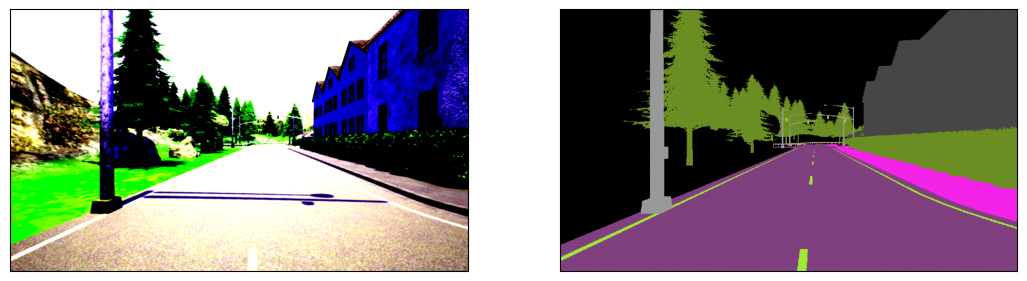

In [24]:
for batch in train_dl:

    imgs = batch['image']
    labels = batch['labels']

    fig, axs = plt.subplots(1, 2, figsize=(13, 13))
    idx = 1
    
    visualize_scene(imgs[idx], axs[0])
    visualize_annotation(labels[idx].cpu().numpy(),axs[1])
    
    break

## Class frequency
This is a brief overview of the frequency of the various classes. We can observe that the most prominent ones are "road" and "unlabeled." This is expected, given that all of the scenes are of city streets, and the unlabeled pixels are the background or the sky.

  0%|          | 0/129 [00:00<?, ?it/s]

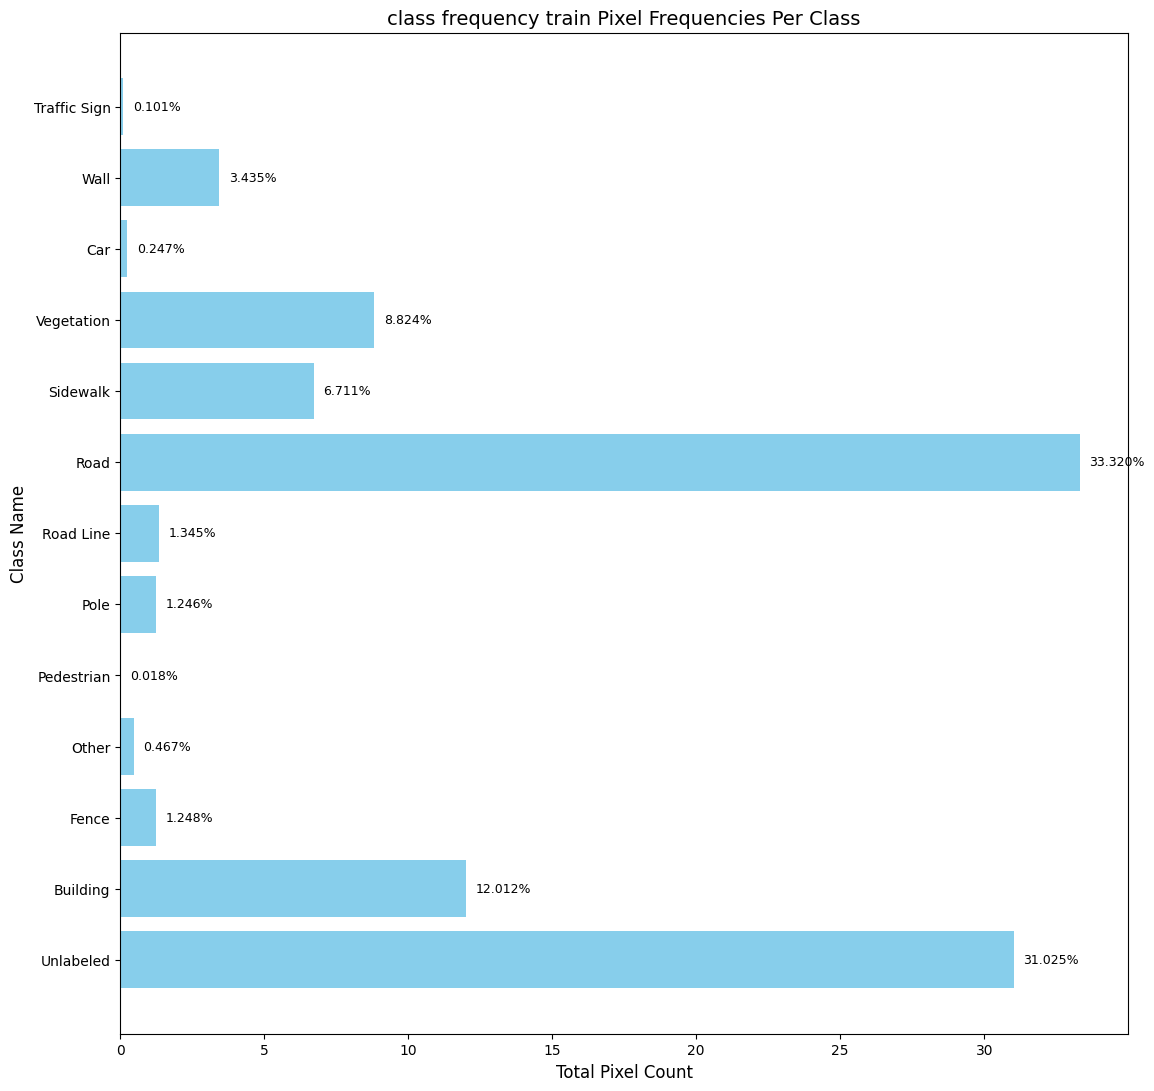

In [25]:
inverse_class_weights_val = compute_class_frequency(StreetHazardsDataset(odgt_file= val_odgt_file,
                                                            image_resize = (512, 896),
                                                            spatial_transforms=None,
                                                            mean_std=None),num_classes=13)


fig, axs = plt.subplots(figsize=(13, 13))
plot_class_frequency(inverse_class_weights_train,inverse_class_weights_train.sum(),axs, "class frequency train")

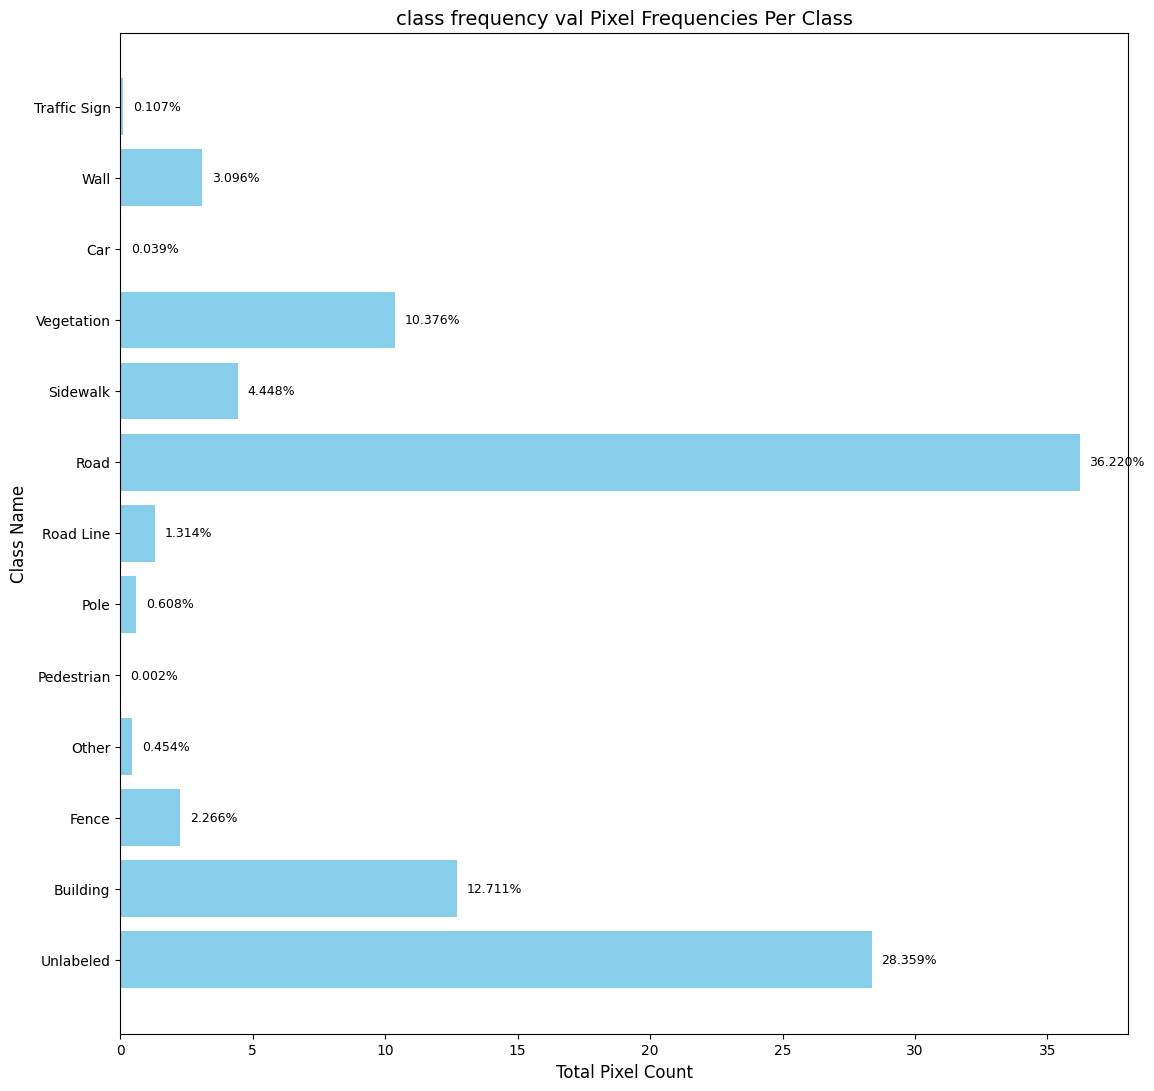

In [26]:
fig, axs = plt.subplots(figsize=(13, 13))
plot_class_frequency(inverse_class_weights_val,inverse_class_weights_val.sum(),axs, "class frequency val")

## Mix dataset
The dual decoder method requires a dataset with anomalies during training, so a dataset with injected anomalies was created. To also improve generalization during training, the images in the dataset were transformed with several image augmentation methods, like color jittering and Gaussian blur.
This is a small snapshot of an image from the dataset. The anomalies were sourced from the Semantic Boundaries Dataset (SBD), which contains annotations for images from the PASCAL VOC 2011 dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


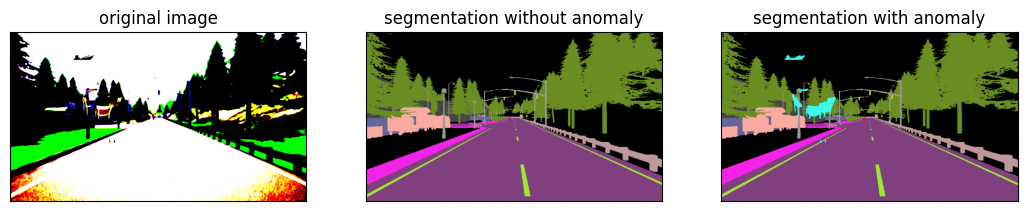

In [27]:
for batch in mix_train_dl:

    imgs = batch['image']
    labels_original = batch['labels_original']
    labels_anomaly = batch['labels_anomaly']

    fig, axs = plt.subplots(1, 3, figsize=(13, 13))
    idx = 1
    
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(labels_original[idx],axs[1],title = "segmentation without anomaly")
    visualize_annotation(labels_anomaly[idx],axs[2],title = "segmentation with anomaly")
    
    break

## Loading the different model
Given the complex combination of losses for the network, different combinations of them were tested.
The starting point were these parameters:
1.  objective_weight = 0.5 - weight of the objectosphere loss
2.  contrastive_weight = 0.5 - weight of the contrastive loss
3.  threshold = 1 - threshold of the objectosphere loss
4.  temperature = 0.1 - temperature of the contrastive loss
5.  cross_weight = 1 - weight of the cross-entropy loss
6.  feat_weight = 0.9 - weight of the feature vector loss
7.  lr = 0.0001 - learning rate

Starting from these parameters, the hyperparameters for one decoder at a time were perturbed to see how the metrics changed.


In [28]:
results = OSS_dual_decoder.models_metrics(Dual_decoder_models,[MeanIoU(),AUPR(13)],model_name="DualDecoder")

  0%|          | 0/8 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

,epoch,obje,contr,thre,t,cross,feat,feat_suffix,lr,model,Mean IoU,AUPR
0,50,1.0,0.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.083305,0.024456
1,50,0.5,0.5,1,0.1,1.0,0.9,mean,0.0001,DualDecoder,0.056282,0.016313
2,50,0.5,1.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.002601,0.013815
3,50,1.0,0.5,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.038799,0.011439
4,50,0.0,1.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.034453,0.008548
5,50,0.5,0.5,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.055113,0.043534
6,50,0.5,0.5,1,0.1,0.5,0.5,mean,0.0001,DualDecoder,0.040652,0.043642
7,50,0.5,0.5,1,0.1,0.9,0.1,sum,0.0001,DualDecoder,0.202483,0.026340


# best model AUPR

The best model for the AUPR is the one with the following parameters:
1.  objective_weight = 0.5
2.  contrastive_weight = 0.5
3.  threshold = 1
4.  temperature = 0.1
5.  cross_weight = 0.9
6.  feat_weight = 0.1
7.  lr = 0.0001

Now, I will show some qualitative results.

model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


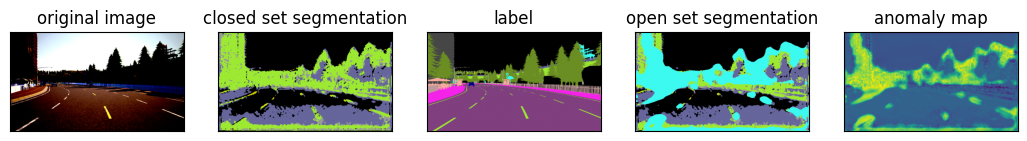

In [29]:
bestAUPR_dual = results.sort_values(by='AUPR', ascending=False).iloc[0]
OSS_dual_decoder.loadModel(Dual_decoder_models[bestAUPR_dual["key"]]["weights_best"])
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_dual_decoder.inference(batch)
    final_map, anomaly = OSS_dual_decoder.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

## plot of the losses

The Loss of the Dual Decoder behave in a real strange way, with an high peak for both the the validation and the train, this is probably due to the discriminitave loss starting to be calculated on the second epoch of the training. 

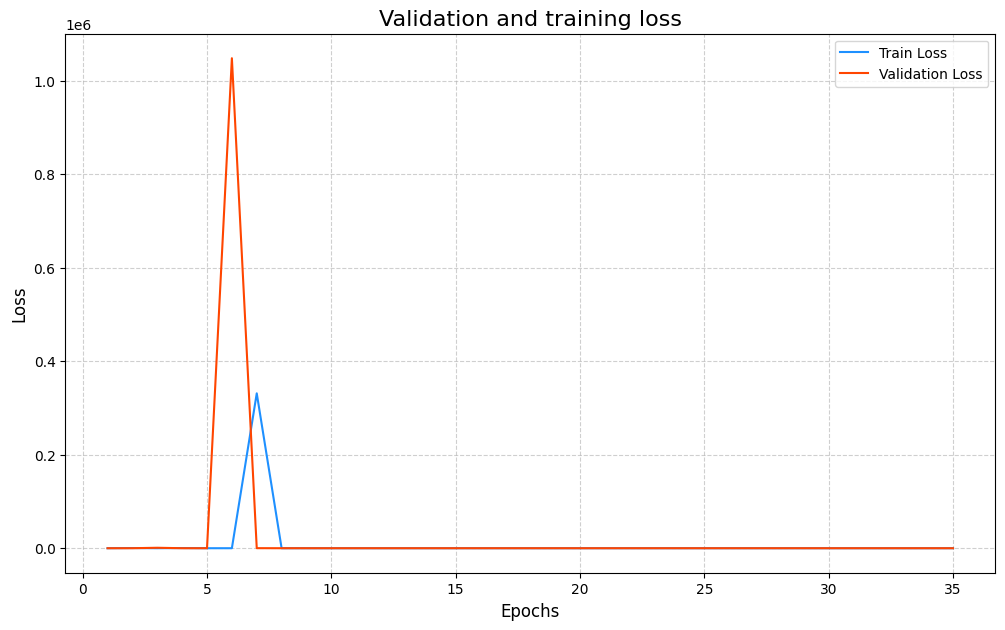

In [30]:
train_loss = np.load(Dual_decoder_models[bestAUPR_dual["key"]]["train_losses"])
val_loss = np.load(Dual_decoder_models[bestAUPR_dual["key"]]["val_losses"])

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, color='dodgerblue', label='Train Loss')

plt.plot(epochs, val_loss, color='orangered', label='Validation Loss')

plt.title('Validation and training loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6) 


# best model MeanIoU

The best model for the mean IoU is the one with the following parameters:
1.  objective_weight = 0.5
2.  contrastive_weight = 0.5
3.  threshold = 1
4.  temperature = 0.1
5.  cross_weight = 0.9
6.  feat_weight = 0.1
7.  lr = 0.0001

Now, I will show some qualitative results.

model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


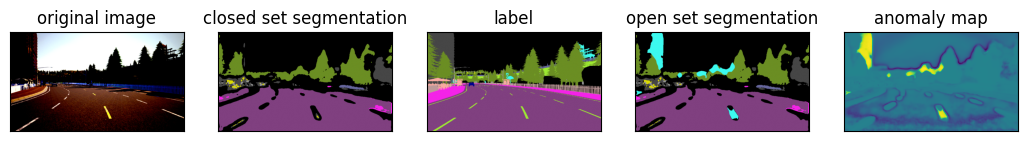

In [31]:
bestMIoU_dual = results.sort_values(by='Mean IoU', ascending=False).iloc[0]
OSS_dual_decoder.loadModel(Dual_decoder_models[bestMIoU_dual["key"]]["weights_best"])
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_dual_decoder.inference(batch)
    final_map, anomaly = OSS_dual_decoder.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

## Plot of the Losses

Here we can see the same behaviour of before, this time after the peak the loss is not zero, but still seems to be a bad progression give the repetion of higher peaks in the validation loss

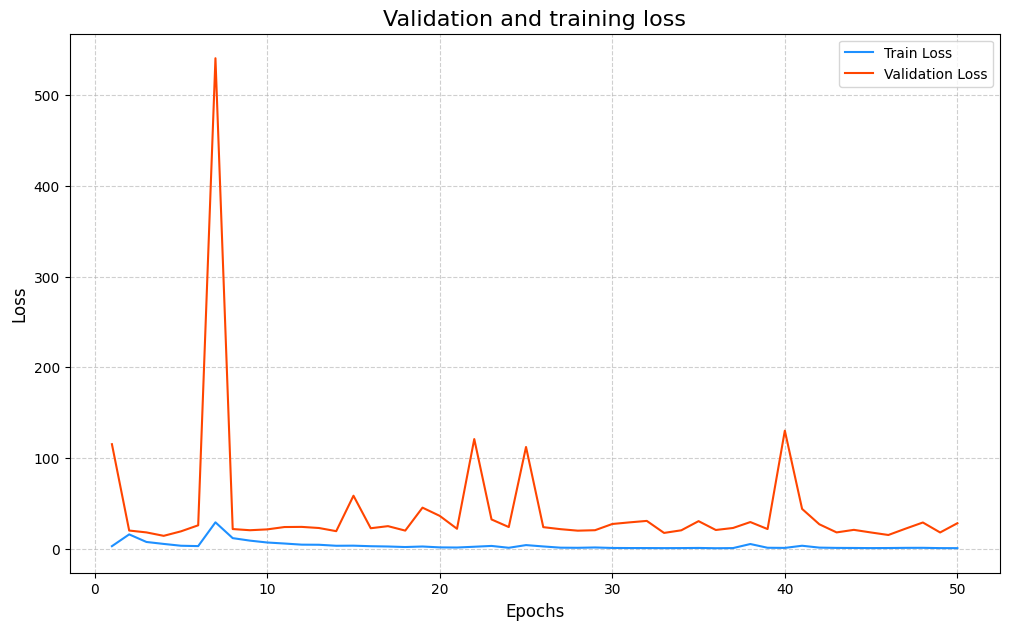

In [32]:
train_loss = np.load(Dual_decoder_models[bestMIoU_dual["key"]]["train_losses"])
val_loss = np.load(Dual_decoder_models[bestMIoU_dual["key"]]["val_losses"])

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, color='dodgerblue', label='Train Loss')

plt.plot(epochs, val_loss, color='orangered', label='Validation Loss')

plt.title('Validation and training loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6) 


## Varying the loss of the semantic decoder
Let's focus on the rows where only the weights of the semantic decoder vary.
We can see that the changes influence both the segmentation and the anomaly detection; this is not new, because part of the anomaly score comes from the semantic decoder. The best results come from giving more weight to the cross-entropy loss.

In [33]:
grouping_cols = ['obje', 'contr', 'thre', 't']

quasi_duplicates = results[results.groupby(grouping_cols).transform('size') >= 1]

quasi_duplicates.sort_values(by=grouping_cols).drop(columns=['key'])

,epoch,obje,contr,thre,t,cross,feat,feat_suffix,lr,model,Mean IoU,AUPR
4,50,0.0,1.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.034453,0.008548
1,50,0.5,0.5,1,0.1,1.0,0.9,mean,0.0001,DualDecoder,0.056282,0.016313
5,50,0.5,0.5,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.055113,0.043534
6,50,0.5,0.5,1,0.1,0.5,0.5,mean,0.0001,DualDecoder,0.040652,0.043642
7,50,0.5,0.5,1,0.1,0.9,0.1,sum,0.0001,DualDecoder,0.202483,0.026340
2,50,0.5,1.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.002601,0.013815
0,50,1.0,0.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.083305,0.024456
3,50,1.0,0.5,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.038799,0.011439


## Varying the loss of the discriminative decoder


In [34]:
grouping_cols = ['cross', 'feat']

quasi_duplicates = results[results.groupby(grouping_cols).transform('size') >= 1]

quasi_duplicates.sort_values(by=grouping_cols).drop(columns=['key'])

,epoch,obje,contr,thre,t,cross,feat,feat_suffix,lr,model,Mean IoU,AUPR
6,50,0.5,0.5,1,0.1,0.5,0.5,mean,0.0001,DualDecoder,0.040652,0.043642
0,50,1.0,0.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.083305,0.024456
2,50,0.5,1.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.002601,0.013815
3,50,1.0,0.5,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.038799,0.011439
4,50,0.0,1.0,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.034453,0.008548
5,50,0.5,0.5,1,0.1,0.9,0.1,mean,0.0001,DualDecoder,0.055113,0.043534
7,50,0.5,0.5,1,0.1,0.9,0.1,sum,0.0001,DualDecoder,0.202483,0.026340
1,50,0.5,0.5,1,0.1,1.0,0.9,mean,0.0001,DualDecoder,0.056282,0.016313


# Second Method "Deep Metric Learning"
This method while using a simple DeepLabV3+ as network, it approach the problem by using a metric learning approach by pushing the object in metric space to cluster around the prototype so to leave the anomalous object isolated.

In [35]:
OSS_Deep_metric = OpenSetSegmentation(DLV3, device,[],Constrastive_Decoder_loss = cd_loss,Semantic_Decoder_loss =sd_loss,method="DML_net",DML_Loss=dml_loss)
results_Deep_metric = OSS_Deep_metric.models_metrics(deepMetric_models,[MeanIoU(),AUPR(13)],model_name="Dual_Decoder_MaxLogit")

  0%|          | 0/5 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

,epoch,lambda,lr,model,Mean IoU,AUPR
0,50,100.00,0.0001,Dual_Decoder_MaxLogit,0.523381,0.069242
1,50,0.01,0.0001,Dual_Decoder_MaxLogit,0.431180,0.069849
2,50,10.00,0.0001,Dual_Decoder_MaxLogit,0.507359,0.067098
3,50,0.10,0.0001,Dual_Decoder_MaxLogit,0.394015,0.077617
4,50,1.00,0.0001,Dual_Decoder_MaxLogit,0.494077,0.066513


# best model AUPR

This is the best model for AUPR reached with the lambda_weight parameter equal to 0.1, indicating that giving low weight to the variance loss helps with the task of anomaly, but worsen the performance of the segmentation. 

model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


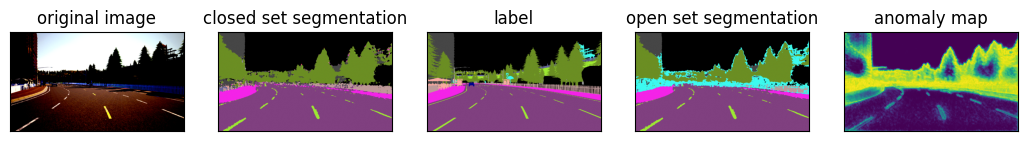

In [36]:
bestAUPR = results_Deep_metric.sort_values(by='AUPR', ascending=False).iloc[0]
OSS_Deep_metric.loadModel(deepMetric_models[bestAUPR["key"]]["weights_best"])
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_Deep_metric.inference(batch)
    final_map, anomaly = OSS_Deep_metric.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

# Showing the loss

The loss of the Deep metric Learning has a much better behaviour with a plateau at the end of the training.

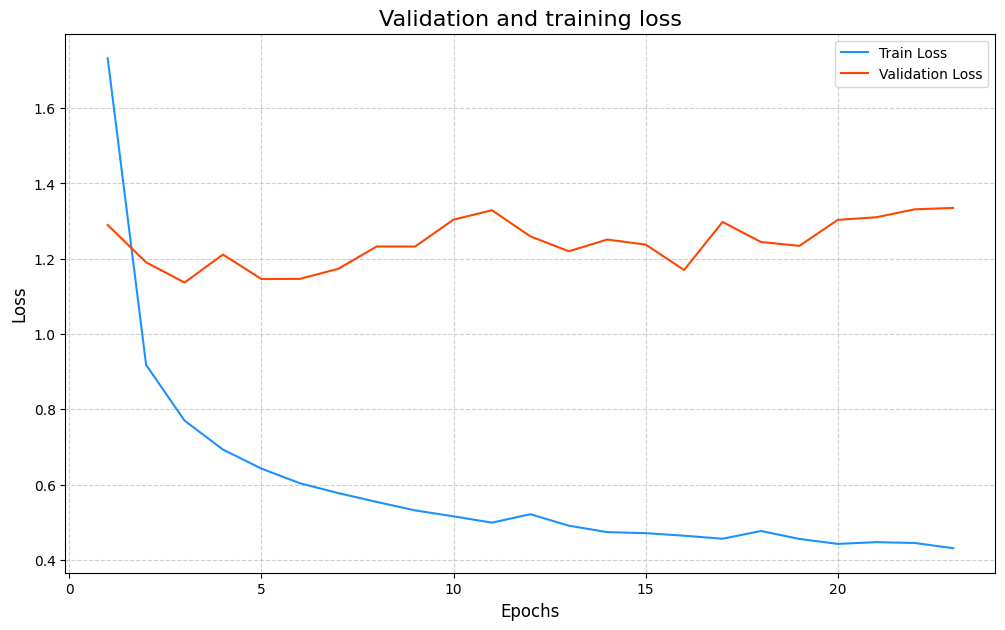

In [37]:
train_loss = np.load(deepMetric_models[bestAUPR["key"]]["train_losses"])
val_loss = np.load(deepMetric_models[bestAUPR["key"]]["val_losses"])

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, color='dodgerblue', label='Train Loss')

plt.plot(epochs, val_loss, color='orangered', label='Validation Loss')

plt.title('Validation and training loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6) 


# best model Mean IoU

This is the best model for Mean IoU reached with the lambda_weight parameter equal to 100

model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


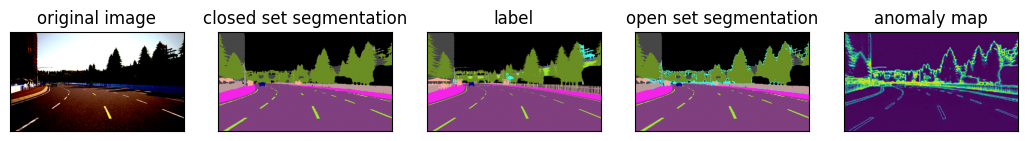

In [38]:
bestMIoU = results_Deep_metric.sort_values(by='Mean IoU', ascending=False).iloc[0]
OSS_Deep_metric.loadModel(deepMetric_models[bestMIoU["key"]]["weights_best"])
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_Deep_metric.inference(batch)
    final_map, anomaly = OSS_Deep_metric.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

# Showing the loss

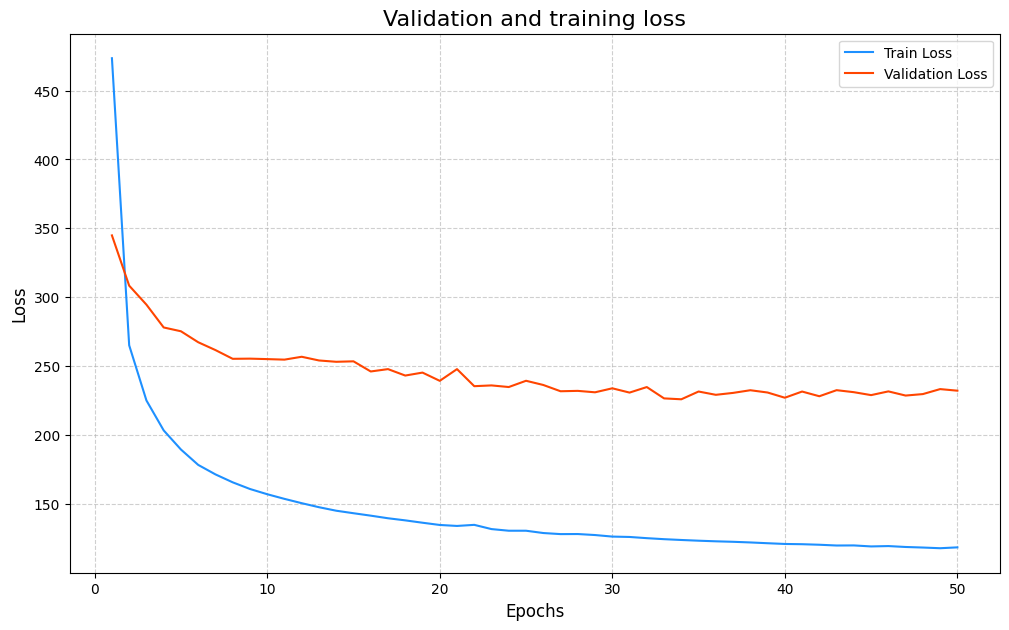

In [39]:
train_loss = np.load(deepMetric_models[bestMIoU["key"]]["train_losses"])
val_loss = np.load(deepMetric_models[bestMIoU["key"]]["val_losses"])

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, color='dodgerblue', label='Train Loss')

plt.plot(epochs, val_loss, color='orangered', label='Validation Loss')

plt.title('Validation and training loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6) 


# Third Method "Standardized Max Logits"
This is a model agnostic method, which means that it works independently of the neural network used. To test this, the idea was to see how this method performed with a classical DeepLabV3+ trained with CrossEntropy and with the trained network of the two previous method

## Max Logit with the best segmenter of the dual decoder
The max logit method starts from the pre softmax logits for the segmentation, so to test this method, the model with the highest Mean IoU for the Dual decoder was chosen.

In [40]:
best_segmenter_weight = Dual_decoder_models[bestMIoU_dual["key"]]["weights_best"]
OSS_max_logit = OpenSetSegmentation(Net, device,[],Constrastive_Decoder_loss = cd_loss,Semantic_Decoder_loss =sd_loss,method="Dual_Decoder_MaxLogit")
OSS_max_logit.loadModel(best_segmenter_weight)

model loaded


In [41]:
class_means , class_stds = calculate_statistics(OSS_max_logit.model,train_dl,13,device)

computing the statistics:   0%|          | 0/640 [00:00<?, ?it/s]

In [42]:
single_model = get_model_by_key(Dual_decoder_models, bestMIoU_dual["key"])
results_MaxLogit = OSS_max_logit.models_metrics(single_model,[MeanIoU(),AUPR(13)],model_name="Dual_Decoder_MaxLogit",class_means=class_means , class_stds=class_stds)

  0%|          | 0/1 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

,epoch,obje,contr,thre,t,cross,feat,feat_suffix,lr,model,Mean IoU,AUPR
0,50,0.5,0.5,1,0.1,0.9,0.1,sum,0.0001,Dual_Decoder_MaxLogit,0.202483,0.029839


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


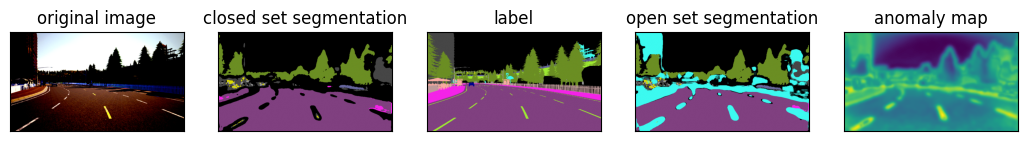

In [43]:
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_max_logit.inference(batch,class_means=class_means , class_stds=class_stds)
    final_map, anomaly = OSS_max_logit.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

## Max Logit with the best segmenter of the DML_net
The max logit method starts from the pre softmax logits for the segmentation, so to test the method, the model with the highest Mean IoU for the DML_net was chosen.

In [44]:
best_segmenter_weight = deepMetric_models[bestMIoU["key"]]["weights_best"]
OSS_Deep_metric = OpenSetSegmentation(DLV3, device,[],Constrastive_Decoder_loss = cd_loss,Semantic_Decoder_loss =sd_loss,method="DML_net_MaxLogit",DML_Loss=dml_loss)
OSS_Deep_metric.loadModel(best_segmenter_weight)

model loaded


In [45]:
class_means , class_stds = calculate_statistics(OSS_Deep_metric.model,train_dl,13,device)

computing the statistics:   0%|          | 0/640 [00:00<?, ?it/s]

In [46]:
single_model = get_model_by_key(deepMetric_models, bestMIoU["key"])
results_MaxLogit = OSS_Deep_metric.models_metrics(single_model,[MeanIoU(),AUPR(13)],model_name="DML_net_MaxLogit",class_means=class_means , class_stds=class_stds)

  0%|          | 0/1 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

,epoch,lambda,lr,model,Mean IoU,AUPR
0,50,100,0.0001,DML_net_MaxLogit,0.523381,0.054628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


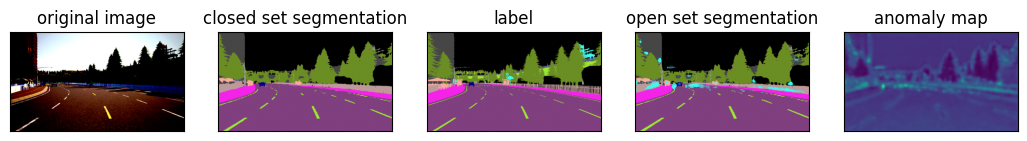

In [47]:
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_Deep_metric.inference(batch,class_means=class_means , class_stds=class_stds)
    final_map, anomaly = OSS_Deep_metric.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 7
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

## Max Logit with classic segmenter trained with crossEntropy
Now we see, as baseline, how the model performs when the logits come from a CrossEntropy trained DeepLabV3+.

In [48]:
OSS_max_logit_standard = OpenSetSegmentation(DLV3, device,[],method="MaxLogit Standard",class_weight=inverse_class_weights_train)
OSS_max_logit_standard.loadModel(segmentation_models["50_epoch_CrossEntropy_segmentationStandard_lr0.0001"]["weights_best"])

model loaded


In [49]:
class_means , class_stds = calculate_statistics(OSS_max_logit_standard.model,train_dl,13,device)

computing the statistics:   0%|          | 0/640 [00:00<?, ?it/s]

Attenzione: Nessun pixel è stato predetto per la classe 3. Vengono usati valori di default.
Attenzione: Nessun pixel è stato predetto per la classe 4. Vengono usati valori di default.
Attenzione: Nessun pixel è stato predetto per la classe 10. Vengono usati valori di default.
Attenzione: Nessun pixel è stato predetto per la classe 12. Vengono usati valori di default.


In [50]:
results_MaxLogit = OSS_max_logit_standard.models_metrics(segmentation_models,[MeanIoU(),AUPR(13)],model_name="MaxLogit Standard",class_means=class_means , class_stds=class_stds)

  0%|          | 0/1 [00:00<?, ?it/s]

model loaded


  0%|          | 0/187 [00:00<?, ?it/s]

,epoch,lr,model,Mean IoU,AUPR
0,50,0.0001,MaxLogit Standard,0.323572,0.046114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


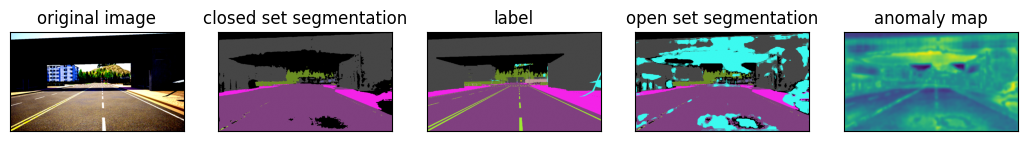

In [51]:
for batch in test_dl:

    imgs = batch['image']
    labels = batch['labels']
    
    segmentation_map, score_map = OSS_max_logit_standard.inference(batch,class_means=class_means , class_stds=class_stds)
    final_map, anomaly = OSS_max_logit_standard.anomaly_map(batch,score_map,segmentation_map,0.6)
    fig, axs = plt.subplots(1, 5, figsize=(13, 13))
    idx = 1
    visualize_scene(imgs[idx], axs[0],title="original image")
    visualize_annotation(segmentation_map[idx].cpu().numpy(), axs[1],title="closed set segmentation")
    visualize_annotation(labels[idx].cpu().numpy(),axs[2],title="label")
    visualize_annotation(final_map[idx].cpu().numpy(), axs[3],title="open set segmentation")
    visualize_scene(anomaly[idx].cpu().numpy(), axs[4],title="anomaly map")
    break

# Conclusion

This study provides a comprehensive evaluation of three distinct methodologies for anomaly detection within semantic segmentation frameworks: a custom Dual Decoder architecture, the model-agnostic Standardized Max Logits (SML) technique, and a Deep Metric Learning (DML) approach.

**1. Dual Decoder Architecture**
The Dual Decoder model, designed to be trained end-to-end for simultaneous segmentation and anomaly detection, yielded modest results. Despite the theoretical appeal of a multi-task learning approach, the complex architecture appeared to struggle with the optimization landscape of the open-set segmentation task.
*   **Performance:** The best configuration for Mean IoU achieved a score of **0.202** while the best one for the AUPR achieved a score of **0.043**. These relatively low scores indicate that the model had difficulty balancing the competing objectives of semantic classification and anomaly reconstruction.
*   **Key Insight:** Extensive hyperparameter tuning regarding loss weighting revealed an interesting anomaly: contrary to standard practices where losses are often averaged, the highest Mean IoU was observed when the loss components were **summed**. This suggests that the magnitude of the gradients played a crucial role in convergence.

**2. Deep Metric Learning (DML) Approach**
The Deep Metric Learning network (DML_net) proved to be the superior method, significantly outperforming the other architectures. By explicitly structuring the feature space to minimize intra-class variance and maximize inter-class distance, the model learned far more robust representations.
*   **Performance:** The DML approach achieved a dominant Mean IoU of **0.52** and the highest AUPR of **0.077**, again with two different configurations.
*   **Hyperparameters:** The most effective configuration for Mean IoU relied on a high weight for the **variance loss**, while the best one for the AUPR relied on a low weight, indicating that trying to balance repulsive and attractive forces of the Loss in the embedding space is critical for distinguishing anomalies.

**3. Standardized Max Logits (SML) Evaluation**
The SML method was evaluated as a model-agnostic post-processing scoring function. While it offers ease of implementation, its performance was heavily dependent on the quality of the underlying feature extractor.
*   **On Dual Decoder:** When applied to the Dual Decoder's logits, SML yielded the same Mean IoU (0.202) but a lower AUPR (**0.029**) compared to the model's native anomaly head (0.043). This confirms that the Dual Decoder’s dedicated anomaly branch captures information that simple logit thresholding misses.
*   **On Standard DeepLabV3+:** As a baseline, applying SML to a standard DeepLabV3+ model resulted in a Mean IoU of **0.32** and an AUPR of **0.04**, outperforming the complex Dual Decoder but falling short of the DML approach.
*   **On DML_net:** Interestingly, when SML was applied to the DML_net, it achieved the same segmentation score (Mean IoU 0.52) but a lower anomaly detection score (AUPR **0.05**) compared to the native distance-based inference (AUPR 0.077). This highlights that the distance-based metric is a more reliable anomaly indicator than logit confidence for metric learning models.

**Final notes**
The experimental results conclusively identify the **Deep Metric Learning** approach as the most effective strategy. With a Mean IoU of **0.52** and an AUPR of **0.077**, it offers a significant performance margin over both the end-to-end Dual Decoder and standard post-processing techniques.